# Solve the problem leveraging ResNet-50 architecture
In this notebook, we will use the ResNet-50 architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on a different dataset, we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

## Import Libraries
First of all, let's import all the libraries we will need later.

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [2]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/My Drive/Baldi_Cioffo/SplittedDataset.zip" -d "/content"

Mounted at /content/drive


## Set Parameters

In [3]:
DATASET_PATH = "/content/SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models/resnet-50"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [4]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset
The dataset, properly preprocessed, is now located in the local machine.

In [5]:
set_seed()

In [6]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Feature extraction
Firstly, we use the pretrained network to extract feature and we define our classifiers to classify the images.

In [7]:
conv_base = keras.applications.resnet.ResNet50(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [8]:
conv_base.trainable = False

### Experiment 1: one dense layer with 64 neurons
In this first experiment we try a simple configuration with a single dense layer before the output layer.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                6422

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 1.1129 - accuracy: 0.7209
Epoch 00001: val_loss improved from inf to 0.63798, saving model to /content/models/experiment1_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 76s 315ms/step - loss: 1.1129 - accuracy: 0.7209 - val_loss: 0.6380 - val_accuracy: 0.7068
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8452
Epoch 00002: val_loss improved from 0.63798 to 0.50173, saving model to /content/models/experiment1_feature_extraction.h5
200/200 [==============================] - 60s 298ms/step - loss: 0.3497 - accuracy: 0.8452 - val_loss: 0.5017 - val_accuracy: 0.7791
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9081
Epoch 00003: val_loss improved from 0.50173 to 0.39897, saving model to /content/models/experiment1_feature_extraction.h5
200/200 [==============================] - 60s 298ms/step - loss: 0.2345 - accuracy: 0.9081 - val_loss: 0.3990 - val_accuracy: 0.8424
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9265
Epoch 00004: val_loss did not improve from 0.39897
200/200 [======

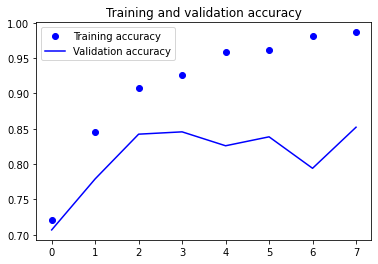

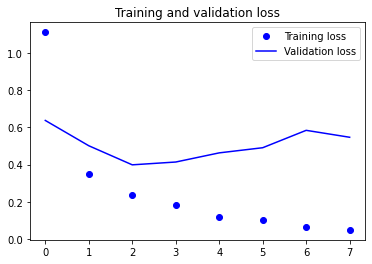

In [ ]:
run_model(model1, 'experiment1_feature_extraction', epochs = 30)

Classification report: 
              precision    recall  f1-score   support

           0     0.7655    0.7270    0.7458       696
           1     0.8709    0.8921    0.8814      1437

    accuracy                         0.8383      2133
   macro avg     0.8182    0.8096    0.8136      2133
weighted avg     0.8365    0.8383    0.8371      2133



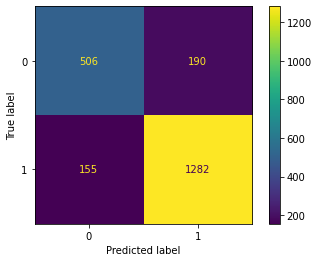

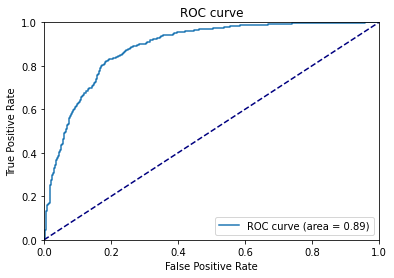

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5'))

### Experiment 2: one dense layer with 32 neurons
We tried to lower the number of neurons, to fight overfitting

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 32)                3211296   
                                                             

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 1.6126 - accuracy: 0.7140
Epoch 00001: val_loss improved from inf to 0.51573, saving model to /content/models/experiment8_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 73s 295ms/step - loss: 1.6126 - accuracy: 0.7140 - val_loss: 0.5157 - val_accuracy: 0.7992
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.7799
Epoch 00002: val_loss did not improve from 0.51573
200/200 [==============================] - 56s 280ms/step - loss: 0.4699 - accuracy: 0.7799 - val_loss: 0.5972 - val_accuracy: 0.8035
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7841
Epoch 00003: val_loss did not improve from 0.51573
200/200 [==============================] - 56s 280ms/step - loss: 0.5071 - accuracy: 0.7841 - val_loss: 0.5653 - val_accuracy: 0.8293
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8238
Epoch 00004: val_loss improved from 0.51573 to 0.48392, saving model to /content/models/experiment8_feature_extraction.h5
200/200 [==============================] - 57s 284ms/step - loss: 0.4068 - accuracy: 0

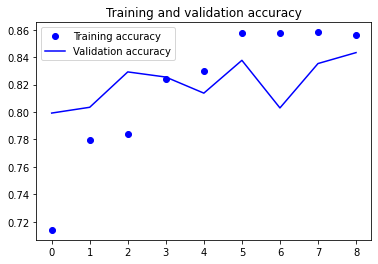

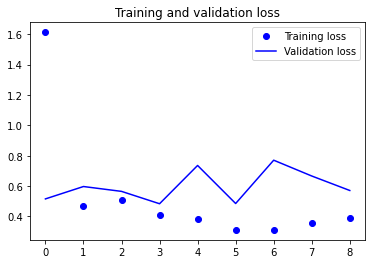

In [ ]:
run_model(model2, 'experiment2_feature_extraction', epochs = 30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8682    0.5489    0.6725       696
           1     0.8145    0.9596    0.8812      1437

    accuracy                         0.8256      2133
   macro avg     0.8414    0.7542    0.7768      2133
weighted avg     0.8320    0.8256    0.8131      2133



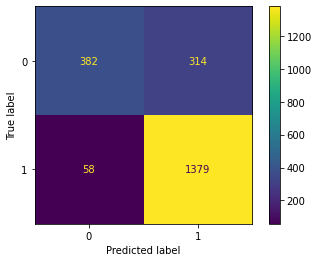

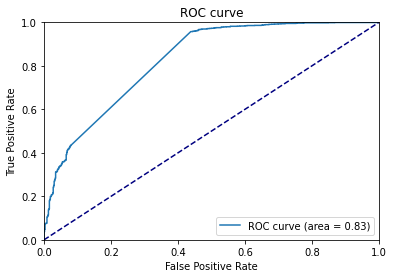

In [9]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction.h5'))

### Experiment 3: one dense layer with 64 neurons and dropout
Lowering the capacity of the networks leads us to underfitting, we could try to use Dropout instead.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                6422

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 1.3604 - accuracy: 0.6901
Epoch 00001: val_loss improved from inf to 0.61554, saving model to /content/models/experiment2.1_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 59s 295ms/step - loss: 1.3604 - accuracy: 0.6901 - val_loss: 0.6155 - val_accuracy: 0.7913
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.7414
Epoch 00002: val_loss improved from 0.61554 to 0.56633, saving model to /content/models/experiment2.1_feature_extraction.h5
200/200 [==============================] - 56s 280ms/step - loss: 0.5552 - accuracy: 0.7414 - val_loss: 0.5663 - val_accuracy: 0.8218
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5233 - accuracy: 0.7633
Epoch 00003: val_loss improved from 0.56633 to 0.54047, saving model to /content/models/experiment2.1_feature_extraction.h5
200/200 [==============================] - 57s 282ms/step - loss: 0.5233 - accuracy: 0.7633 - val_loss: 0.5405 - val_accuracy: 0.8175
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.7903
Epoch 00004: val_loss did not improve from 0.54047
200/200 [==

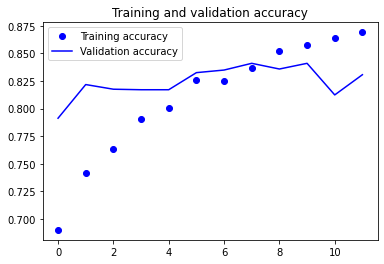

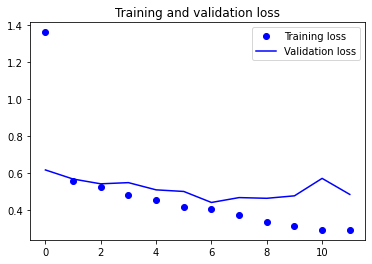

In [ ]:
run_model(model3, 'experiment3_feature_extraction', epochs = 50)

Classification report: 
              precision    recall  f1-score   support

           0     0.8003    0.6624    0.7248       696
           1     0.8491    0.9200    0.8831      1437

    accuracy                         0.8359      2133
   macro avg     0.8247    0.7912    0.8040      2133
weighted avg     0.8332    0.8359    0.8315      2133



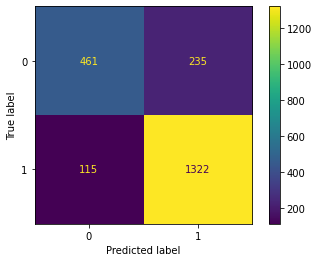

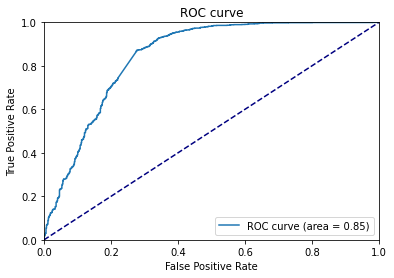

In [10]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction.h5'))

### Experiment 4: global average pooling
Try GlobalAveragePooling instead of fully connected layers, to lower the number of parameters.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.7278
Epoch 00001: val_loss improved from inf to 0.53359, saving model to /content/models/experiment4_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 79s 312ms/step - loss: 0.5440 - accuracy: 0.7278 - val_loss: 0.5336 - val_accuracy: 0.7448
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.7611
Epoch 00002: val_loss improved from 0.53359 to 0.51073, saving model to /content/models/experiment4_feature_extraction.h5
200/200 [==============================] - 59s 295ms/step - loss: 0.4911 - accuracy: 0.7611 - val_loss: 0.5107 - val_accuracy: 0.7659
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.7811
Epoch 00003: val_loss improved from 0.51073 to 0.47132, saving model to /content/models/experiment4_feature_extraction.h5
200/200 [==============================] - 59s 296ms/step - loss: 0.4635 - accuracy: 0.7811 - val_loss: 0.4713 - val_accuracy: 0.7880
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.7874
Epoch 00004: val_loss improved from 0.47132 to 0.45415, saving mod

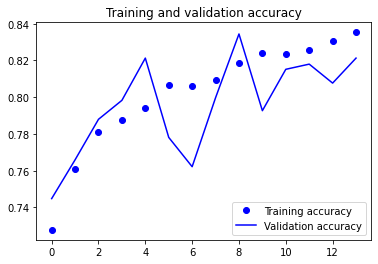

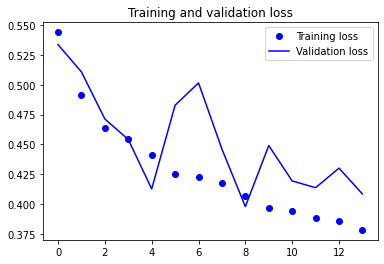

In [ ]:
run_model(model4, "experiment4_feature_extraction", epochs=20)

Classification report: 
              precision    recall  f1-score   support

           0     0.7971    0.6997    0.7452       696
           1     0.8627    0.9137    0.8875      1437

    accuracy                         0.8439      2133
   macro avg     0.8299    0.8067    0.8163      2133
weighted avg     0.8413    0.8439    0.8410      2133



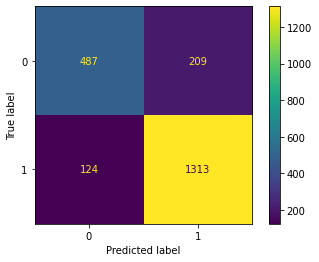

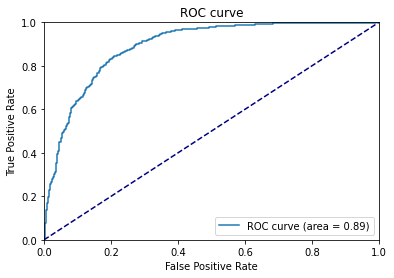

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_feature_extraction.h5'))

### Experiment 5: global average pooling and two dense layers

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model5, optimizer='rmsprop')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.6936
Epoch 00001: val_loss improved from inf to 0.51648, saving model to /content/models/Experiment5_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 66s 306ms/step - loss: 0.6796 - accuracy: 0.6936 - val_loss: 0.5165 - val_accuracy: 0.8025
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7545
Epoch 00002: val_loss improved from 0.51648 to 0.43884, saving model to /content/models/Experiment5_feature_extraction.h5
200/200 [==============================] - 60s 297ms/step - loss: 0.5042 - accuracy: 0.7545 - val_loss: 0.4388 - val_accuracy: 0.8086
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.7730
Epoch 00003: val_loss improved from 0.43884 to 0.39776, saving model to /content/models/Experiment5_feature_extraction.h5
200/200 [==============================] - 60s 297ms/step - loss: 0.4732 - accuracy: 0.7730 - val_loss: 0.3978 - val_accuracy: 0.8326
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.7908
Epoch 00004: val_loss did not improve from 0.39776
200/200 [======

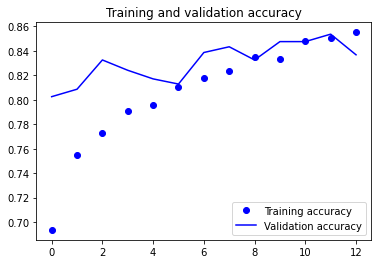

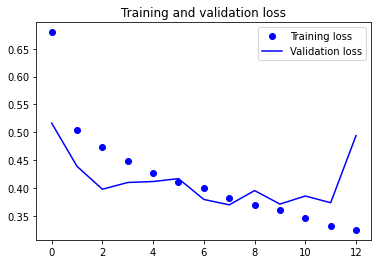

In [ ]:
run_model(model5, 'Experiment5_feature_extraction', epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.8101    0.7170    0.7607       696
           1     0.8701    0.9186    0.8937      1437

    accuracy                         0.8528      2133
   macro avg     0.8401    0.8178    0.8272      2133
weighted avg     0.8505    0.8528    0.8503      2133



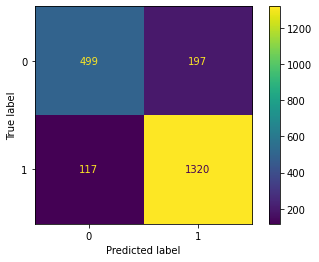

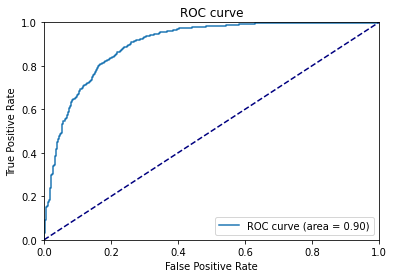

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_feature_extraction.h5'))

## Fine-tuning

### Experiment 1: one dense layer

In [ ]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5')

set_trainable = False
for layer in model1.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model1, learning_rate=1e-5)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                6422

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9256
Epoch 00001: val_loss improved from inf to 0.44843, saving model to /content/models/experiment1_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 78s 322ms/step - loss: 0.1937 - accuracy: 0.9256 - val_loss: 0.4484 - val_accuracy: 0.8138
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9681
Epoch 00002: val_loss improved from 0.44843 to 0.44096, saving model to /content/models/experiment1_fine_tuning.h5
200/200 [==============================] - 61s 306ms/step - loss: 0.1213 - accuracy: 0.9681 - val_loss: 0.4410 - val_accuracy: 0.8218
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9850
Epoch 00003: val_loss did not improve from 0.44096
200/200 [==============================] - 60s 301ms/step - loss: 0.0894 - accuracy: 0.9850 - val_loss: 0.4426 - val_accuracy: 0.8293
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9933
Epoch 00004: val_loss improved from 0.44096 to 0.43861, saving model to /content/models/experiment1_fine_tuning.h5
200/200 [====================

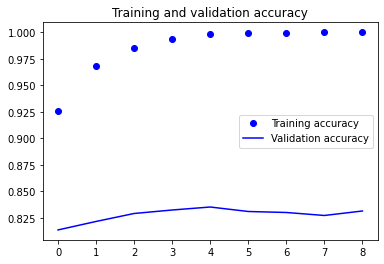

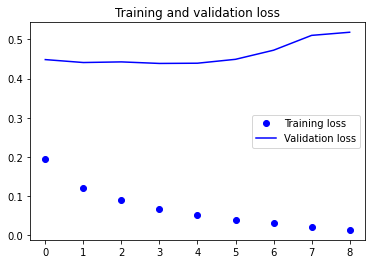

In [ ]:
run_model(model1, "experiment1_fine_tuning", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.7423    0.7945    0.7675       696
           1     0.8970    0.8664    0.8814      1437

    accuracy                         0.8429      2133
   macro avg     0.8196    0.8305    0.8245      2133
weighted avg     0.8465    0.8429    0.8443      2133



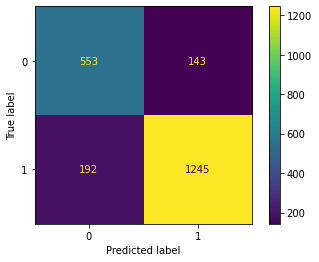

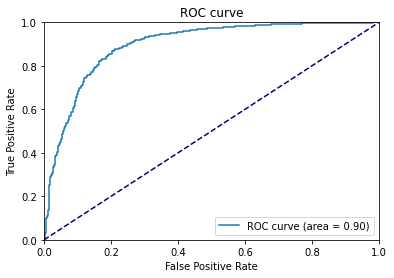

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_fine_tuning.h5'))

### Experiment 2: global average pooling

In [ ]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_feature_extraction.h5')

set_trainable = False
# fine-tune the last three elements
for layer in model4.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model4, learning_rate=1e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.8185
Epoch 00001: val_loss improved from inf to 0.41188, saving model to /content/models/Experiment2_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 72s 317ms/step - loss: 0.4083 - accuracy: 0.8185 - val_loss: 0.4119 - val_accuracy: 0.8171
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8497
Epoch 00002: val_loss improved from 0.41188 to 0.39997, saving model to /content/models/Experiment2_fine_tuning.h5
200/200 [==============================] - 62s 309ms/step - loss: 0.3450 - accuracy: 0.8497 - val_loss: 0.4000 - val_accuracy: 0.8194
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.8813
Epoch 00003: val_loss improved from 0.39997 to 0.39369, saving model to /content/models/Experiment2_fine_tuning.h5
200/200 [==============================] - 63s 311ms/step - loss: 0.3031 - accuracy: 0.8813 - val_loss: 0.3937 - val_accuracy: 0.8246
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.9021
Epoch 00004: val_loss improved from 0.39369 to 0.39332, saving model to /content

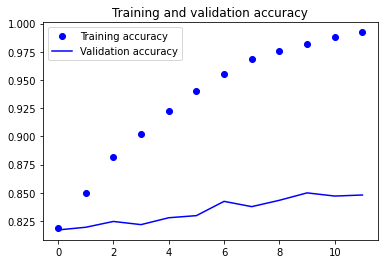

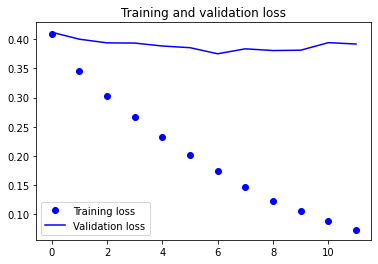

In [ ]:
run_model(model4, "Experiment2_fine_tuning")

Classification report: 
              precision    recall  f1-score   support

           0     0.7776    0.8089    0.7930       696
           1     0.9056    0.8880    0.8967      1437

    accuracy                         0.8622      2133
   macro avg     0.8416    0.8484    0.8448      2133
weighted avg     0.8638    0.8622    0.8628      2133



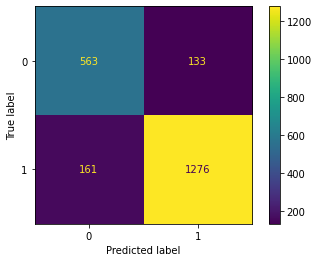

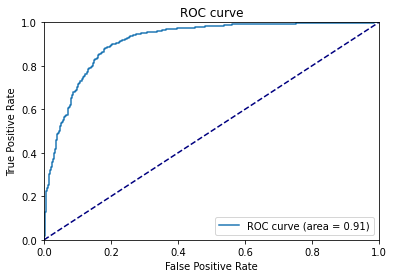

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_fine_tuning.h5'))

### Experiment 3: global average pooling and two dense layers

In [ ]:
model5 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_feature_extraction.h5')

set_trainable = False
for layer in model5.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model5, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.8205
Epoch 00001: val_loss improved from inf to 0.43053, saving model to /content/models/Experiment4_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 66s 307ms/step - loss: 0.5310 - accuracy: 0.8205 - val_loss: 0.4305 - val_accuracy: 0.8288
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8613
Epoch 00002: val_loss improved from 0.43053 to 0.43047, saving model to /content/models/Experiment4_fine_tuning.h5
200/200 [==============================] - 61s 303ms/step - loss: 0.3136 - accuracy: 0.8613 - val_loss: 0.4305 - val_accuracy: 0.8311
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.8915
Epoch 00003: val_loss did not improve from 0.43047
200/200 [==============================] - 60s 299ms/step - loss: 0.2508 - accuracy: 0.8915 - val_loss: 0.4324 - val_accuracy: 0.8279
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9154
Epoch 00004: val_loss improved from 0.43047 to 0.42893, saving model to /content/models/Experiment4_fine_tuning.h5
200/200 [====================

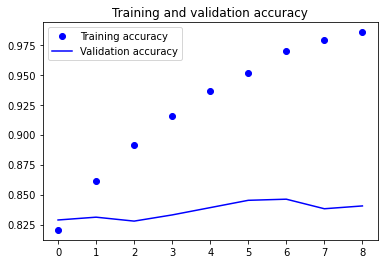

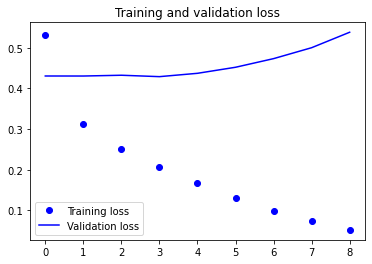

In [ ]:
run_model(model5, "Experiment3_fine_tuning", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.7799    0.8046    0.7921       696
           1     0.9039    0.8900    0.8969      1437

    accuracy                         0.8622      2133
   macro avg     0.8419    0.8473    0.8445      2133
weighted avg     0.8634    0.8622    0.8627      2133



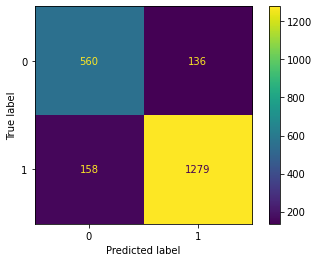

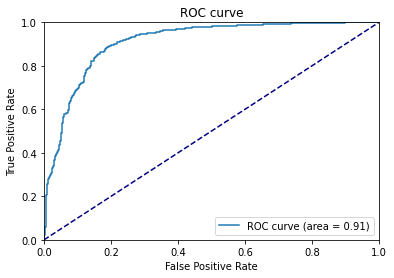

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_fine_tuning.h5'))

## Remove final block (5-th block)
Due to Colab's limitations we only took part of the original dataset, so now our dataset is small and very different from the one the pre-trained network was trained on. In this case it may be good to try to remove some of the final layers of the pre-trained network whose filters deal with finding detailed features. We will use less specific features that we find in previous levels.

In [ ]:
def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [ ]:
conv_base = keras.applications.resnet.ResNet50(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

94781440/94765736 [==============================] - 1s 0us/step


Remove the last convolutionary block of ResNet50.

In [ ]:
base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'conv4_block6_out')].output, name='base')
base.trainable = False
base.summary()

Model: "base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                               

### Feature extraction
Firstly, we will try to use the new base network to extract the features; we will put a classifier on top of the base network. We couldn't afford to use the Flatten, the output of the base network is 14x14x1024, too much. So we decided to use the GlobalAveragePooling2D.

#### Experiment 1: one dense layer with 256 neurons
In this first example we use just a Dense layer before the output layer.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.6934
Epoch 00001: val_loss improved from inf to 0.52617, saving model to /content/models/Experiment2_remove_blocks.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 59s 264ms/step - loss: 0.6664 - accuracy: 0.6934 - val_loss: 0.5262 - val_accuracy: 0.7735
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.7480
Epoch 00002: val_loss did not improve from 0.52617
200/200 [==============================] - 50s 250ms/step - loss: 0.5157 - accuracy: 0.7480 - val_loss: 0.5426 - val_accuracy: 0.7345
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.7538
Epoch 00003: val_loss improved from 0.52617 to 0.45911, saving model to /content/models/Experiment2_remove_blocks.h5
200/200 [==============================] - 50s 251ms/step - loss: 0.5120 - accuracy: 0.7538 - val_loss: 0.4591 - val_accuracy: 0.7889
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.7731
Epoch 00004: val_loss improved from 0.45911 to 0.41217, saving model to /content/models/Experiment2_remove_blocks.h5
200/200 [================

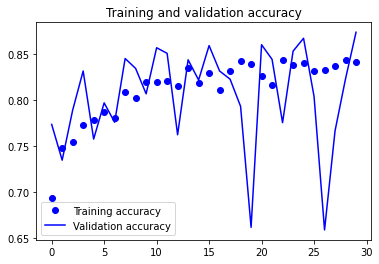

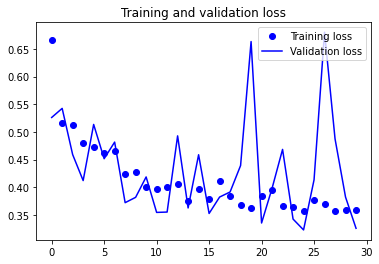

In [ ]:
run_model(model1, "Experiment1_remove_blocks_feature_extraction", epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8453    0.7457    0.7924       696
           1     0.8835    0.9339    0.9080      1437

    accuracy                         0.8725      2133
   macro avg     0.8644    0.8398    0.8502      2133
weighted avg     0.8710    0.8725    0.8703      2133



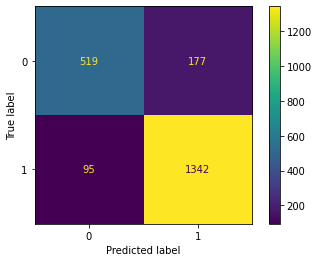

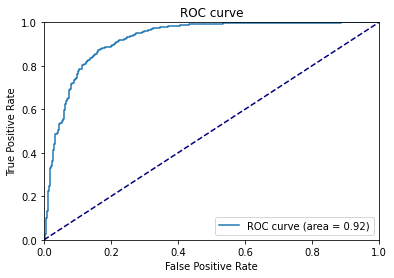

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction.h5'))

#### Experiment 2: one dense layer with 256 neurons and dropout
Try to use Dropout.

In [ ]:
# define the classifier
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.6721
Epoch 00001: val_loss improved from inf to 0.51659, saving model to /content/models/Experiment1_remove_blocks.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 71s 291ms/step - loss: 0.7290 - accuracy: 0.6721 - val_loss: 0.5166 - val_accuracy: 0.7458
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.7205
Epoch 00002: val_loss did not improve from 0.51659
200/200 [==============================] - 51s 251ms/step - loss: 0.5771 - accuracy: 0.7205 - val_loss: 0.5531 - val_accuracy: 0.7242
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.5581 - accuracy: 0.7333
Epoch 00003: val_loss improved from 0.51659 to 0.50040, saving model to /content/models/Experiment1_remove_blocks.h5
200/200 [==============================] - 52s 257ms/step - loss: 0.5581 - accuracy: 0.7333 - val_loss: 0.5004 - val_accuracy: 0.7627
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.7509
Epoch 00004: val_loss improved from 0.50040 to 0.42362, saving model to /content/models/Experiment1_remove_blocks.h5
200/200 [================

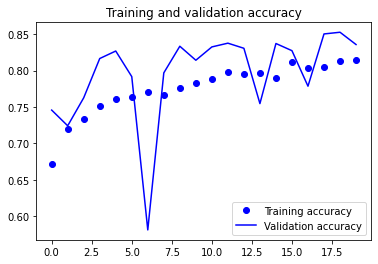

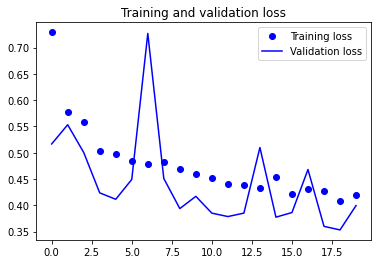

In [ ]:
run_model(model2, "Experiment2_remove_blocks_feature_extraction")

Classification report: 
              precision    recall  f1-score   support

           0     0.8356    0.7083    0.7667       696
           1     0.8684    0.9325    0.8993      1437

    accuracy                         0.8594      2133
   macro avg     0.8520    0.8204    0.8330      2133
weighted avg     0.8577    0.8594    0.8561      2133



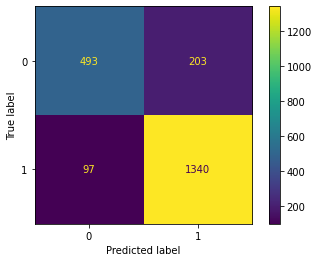

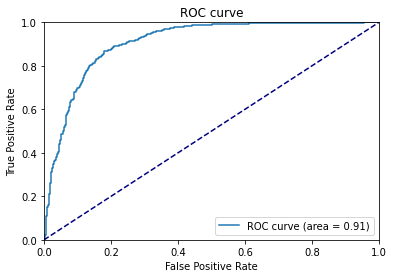

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5'))

#### Experiment 3: two dense layers, 256-128 neurons
Try to make a more complex network, increasing the dense layers.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dense(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.6896
Epoch 00001: val_loss improved from inf to 0.51145, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 67s 268ms/step - loss: 0.6689 - accuracy: 0.6896 - val_loss: 0.5114 - val_accuracy: 0.7481
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.7414
Epoch 00002: val_loss improved from 0.51145 to 0.50001, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5
200/200 [==============================] - 51s 255ms/step - loss: 0.5255 - accuracy: 0.7414 - val_loss: 0.5000 - val_accuracy: 0.7584
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.7514
Epoch 00003: val_loss improved from 0.50001 to 0.49625, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5
200/200 [==============================] - 51s 256ms/step - loss: 0.5047 - accuracy: 0.7514 - val_loss: 0.4962 - val_accuracy: 0.7674
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.7695
Epoch 00004: val_loss improved from 0.

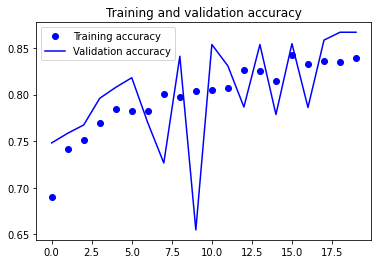

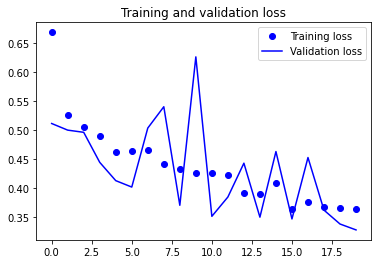

In [ ]:
run_model(model3, "Experiment3_remove_blocks_feature_extraction")

Classification report: 
              precision    recall  f1-score   support

           0     0.8579    0.4943    0.6272       696
           1     0.7968    0.9603    0.8709      1437

    accuracy                         0.8083      2133
   macro avg     0.8273    0.7273    0.7491      2133
weighted avg     0.8167    0.8083    0.7914      2133



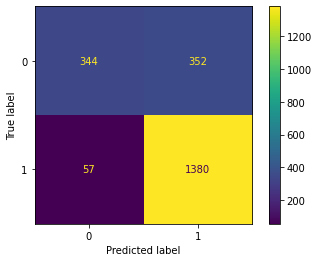

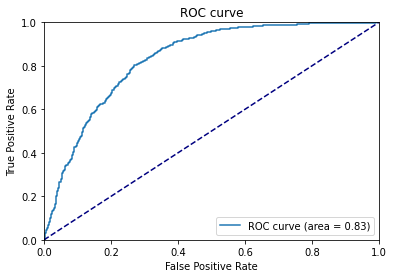

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_remove_blocks_feature_extraction.h5'))

#### Experiment 4: one dense layer with 512 neurons
Try to make a more complex networks increasing the neurons of a single Dense layer. We use RMSprop that in this case give us a smoother learning curve.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4, optimizer='rmsprop', learning_rate=5e-5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.6714
Epoch 00001: val_loss improved from inf to 0.63692, saving model to /content/models/Experiment4_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 65s 308ms/step - loss: 0.6035 - accuracy: 0.6714 - val_loss: 0.6369 - val_accuracy: 0.6299
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.7359
Epoch 00002: val_loss improved from 0.63692 to 0.58422, saving model to /content/models/Experiment4_remove_blocks_feature_extraction.h5
200/200 [==============================] - 61s 304ms/step - loss: 0.5410 - accuracy: 0.7359 - val_loss: 0.5842 - val_accuracy: 0.6914
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.7489
Epoch 00003: val_loss improved from 0.58422 to 0.50221, saving model to /content/models/Experiment4_remove_blocks_feature_extraction.h5
200/200 [==============================] - 61s 303ms/step - loss: 0.5239 - accuracy: 0.7489 - val_loss: 0.5022 - val_accuracy: 0.7552
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.7500
Epoch 00004: val_loss improved from 0.

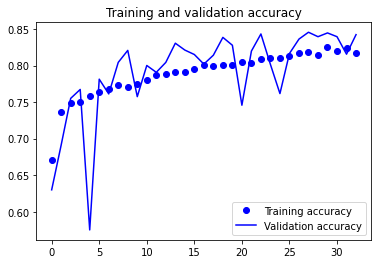

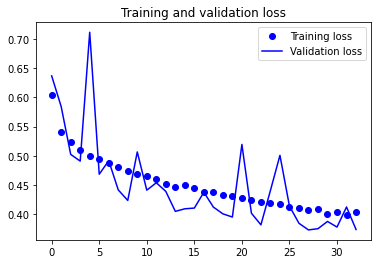

In [ ]:
run_model(model4, "Experiment4_remove_blocks_feature_extraction", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.8733    0.6537    0.7477       696
           1     0.8505    0.9541    0.8993      1437

    accuracy                         0.8561      2133
   macro avg     0.8619    0.8039    0.8235      2133
weighted avg     0.8579    0.8561    0.8499      2133



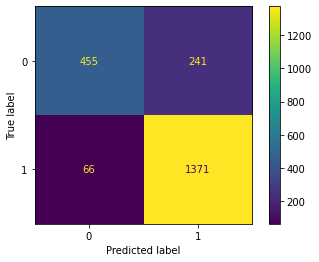

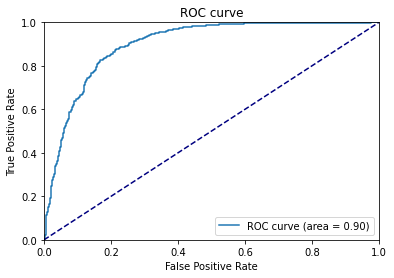

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5'))

#### Experiment 5: two dense layers of 512 neurons 
Try to make a more complex networks with two fully-connected dense layer of 512 neurons. We use RMSprop that in this case give us a smoother learning curve.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model5, optimizer='rmsprop')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.6563
Epoch 00001: val_loss improved from inf to 0.59879, saving model to /content/models/Prova.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 64s 253ms/step - loss: 0.6606 - accuracy: 0.6563 - val_loss: 0.5988 - val_accuracy: 0.7031
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5461 - accuracy: 0.7286
Epoch 00002: val_loss improved from 0.59879 to 0.54641, saving model to /content/models/Prova.h5
200/200 [==============================] - 49s 242ms/step - loss: 0.5461 - accuracy: 0.7286 - val_loss: 0.5464 - val_accuracy: 0.7411
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.7359
Epoch 00003: val_loss improved from 0.54641 to 0.52124, saving model to /content/models/Prova.h5
200/200 [==============================] - 49s 243ms/step - loss: 0.5287 - accuracy: 0.7359 - val_loss: 0.5212 - val_accuracy: 0.7594
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5097 - accuracy: 0.7544
Epoch 00004: val_loss improved from 0.52124 to 0.48964, saving model to /content/models/Prova.h5
200/200 [==========

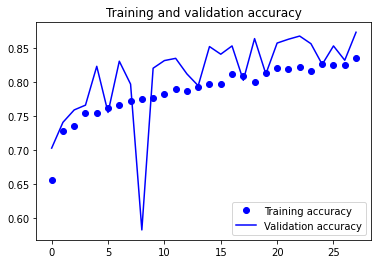

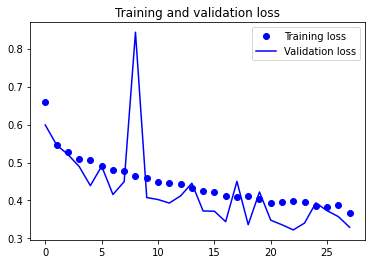

In [ ]:
run_model(model5, "Experiment5_remove_blocks_feature_extraction", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.9004    0.6882    0.7801       696
           1     0.8645    0.9631    0.9111      1437

    accuracy                         0.8734      2133
   macro avg     0.8824    0.8257    0.8456      2133
weighted avg     0.8762    0.8734    0.8684      2133



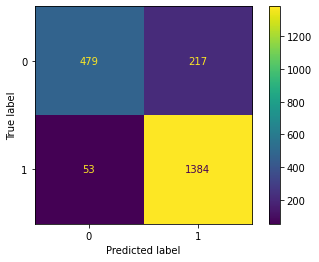

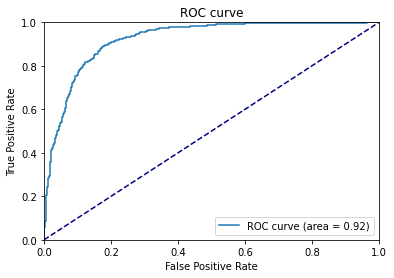

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5'))

### Fine tuning
Now we can fine tune the best models of the previous experiments, unfreezing some of the last layers of the base network.

#### Unfreeze some layers
Firstly, we try to unfreeze just some of the last layers of the fourth block.

##### Experiment 1: one dense layer with 256 neurons and dropout

In [ ]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
# set trainable from "conv4_block6_1_conv"
for layer in model1.get_layer('base').layers:
    if layer.name == 'conv4_block6_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
compile_model(model1, learning_rate=1e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.8721
Epoch 00001: val_loss improved from inf to 0.30570, saving model to /content/models/Experiment1_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 52s 259ms/step - loss: 0.3117 - accuracy: 0.8721 - val_loss: 0.3057 - val_accuracy: 0.8766
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.8799
Epoch 00002: val_loss did not improve from 0.30570
200/200 [==============================] - 52s 257ms/step - loss: 0.2939 - accuracy: 0.8799 - val_loss: 0.3152 - val_accuracy: 0.8630
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.8884
Epoch 00003: val_loss did not improve from 0.30570
200/200 [==============================] - 52s 257ms/step - loss: 0.2772 - accuracy: 0.8884 - val_loss: 0.3133 - val_accuracy: 0.8654
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9006
Epoch 00004: val_loss improved from 0.30570 to 0.29901, saving model to /content/models/Experiment1_remove_blocks_fine_tuning.h5
200/200 [==============================] - 52s 259ms/step - loss: 0.2593 - accu

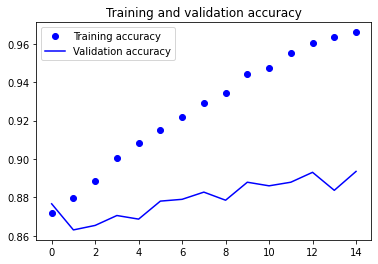

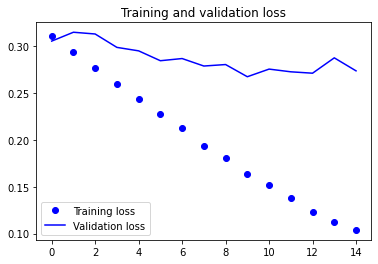

In [ ]:
run_model(model1, 'Experiment1_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8580    0.8420    0.8499       696
           1     0.9241    0.9325    0.9283      1437

    accuracy                         0.9030      2133
   macro avg     0.8911    0.8872    0.8891      2133
weighted avg     0.9026    0.9030    0.9027      2133



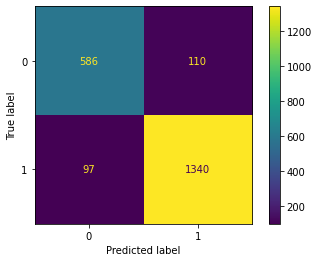

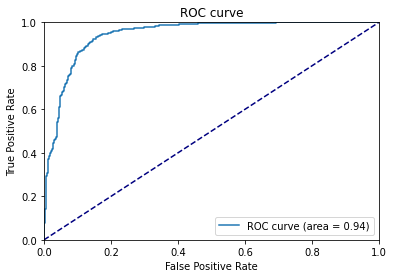

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_fine_tuning.h5'))

##### Experiment 2: one dense layer with 512 neurons

In [ ]:
model2 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
set_trainable = False
# set trainable from "conv4_block6_1_conv"
for layer in model2.get_layer('base').layers:
    if layer.name == 'conv4_block6_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
compile_model(model2, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8247
Epoch 00001: val_loss improved from inf to 0.37360, saving model to /content/models/Experiment2_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 68s 292ms/step - loss: 0.3929 - accuracy: 0.8247 - val_loss: 0.3736 - val_accuracy: 0.8457
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8369
Epoch 00002: val_loss improved from 0.37360 to 0.36857, saving model to /content/models/Experiment2_remove_blocks_fine_tuning.h5
200/200 [==============================] - 56s 278ms/step - loss: 0.3735 - accuracy: 0.8369 - val_loss: 0.3686 - val_accuracy: 0.8447
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.8454
Epoch 00003: val_loss improved from 0.36857 to 0.35322, saving model to /content/models/Experiment2_remove_blocks_fine_tuning.h5
200/200 [==============================] - 56s 279ms/step - loss: 0.3609 - accuracy: 0.8454 - val_loss: 0.3532 - val_accuracy: 0.8565
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8515
Epoch 00004: val_loss improved from 0.35322 to 0.337

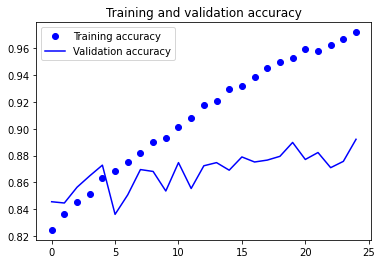

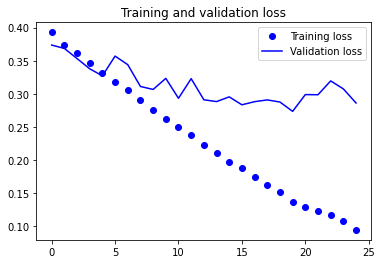

In [ ]:
run_model(model2, 'Experiment2_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8520    0.8434    0.8477       696
           1     0.9245    0.9290    0.9268      1437

    accuracy                         0.9011      2133
   macro avg     0.8882    0.8862    0.8872      2133
weighted avg     0.9008    0.9011    0.9009      2133



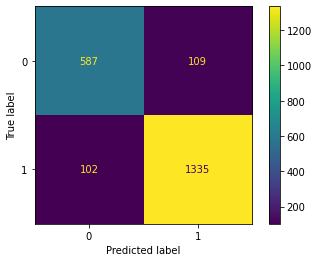

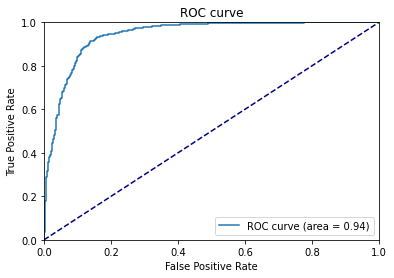

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_fine_tuning.h5'))

#### Unfreeze all the 4-th block
We try to unfreeze more layers, more precisely all the fourth block (that is the last block of our base network).

##### Experiment 3: one dense layer with 256 neurons and dropout

In [ ]:
model3 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
# set trainable all conv4 section
for layer in model3.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
compile_model(model3, learning_rate=1e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8302
Epoch 00001: val_loss improved from inf to 0.36190, saving model to /content/models/Experiment3_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 102s 406ms/step - loss: 0.3894 - accuracy: 0.8302 - val_loss: 0.3619 - val_accuracy: 0.8386
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.8870
Epoch 00002: val_loss improved from 0.36190 to 0.26768, saving model to /content/models/Experiment3_remove_blocks_fine_tuning.h5
200/200 [==============================] - 79s 393ms/step - loss: 0.2831 - accuracy: 0.8870 - val_loss: 0.2677 - val_accuracy: 0.8935
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.9193
Epoch 00003: val_loss did not improve from 0.26768
200/200 [==============================] - 78s 389ms/step - loss: 0.2117 - accuracy: 0.9193 - val_loss: 0.2861 - val_accuracy: 0.8771
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9453
Epoch 00004: val_loss improved from 0.26768 to 0.23268, saving model to /content/models/Experiment3_remove_blocks_fine_tuning.h5


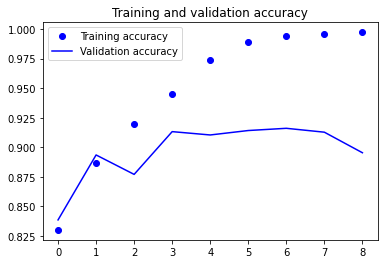

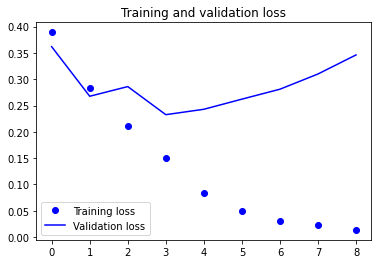

In [ ]:
run_model(model3, 'Experiment3_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8827    0.8434    0.8626       696
           1     0.9257    0.9457    0.9356      1437

    accuracy                         0.9123      2133
   macro avg     0.9042    0.8946    0.8991      2133
weighted avg     0.9117    0.9123    0.9118      2133



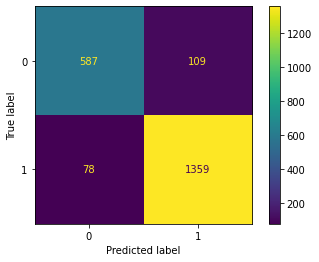

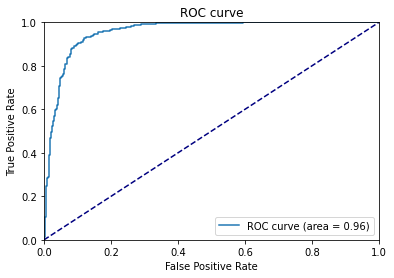

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_remove_blocks_fine_tuning.h5'))

##### Experiment 4: one dense layer with 512 neurons

In [ ]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
set_trainable = False
for layer in model4.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model4, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8449
Epoch 00001: val_loss improved from inf to 0.35933, saving model to /content/models/Experiment4_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 96s 412ms/step - loss: 0.3678 - accuracy: 0.8449 - val_loss: 0.3593 - val_accuracy: 0.8415
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8934
Epoch 00002: val_loss improved from 0.35933 to 0.27451, saving model to /content/models/Experiment4_remove_blocks_fine_tuning.h5
200/200 [==============================] - 82s 407ms/step - loss: 0.2697 - accuracy: 0.8934 - val_loss: 0.2745 - val_accuracy: 0.8856
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9321
Epoch 00003: val_loss improved from 0.27451 to 0.24859, saving model to /content/models/Experiment4_remove_blocks_fine_tuning.h5
200/200 [==============================] - 82s 407ms/step - loss: 0.1918 - accuracy: 0.9321 - val_loss: 0.2486 - val_accuracy: 0.9062
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9567
Epoch 00004: val_loss did not improve from 0.24859
2

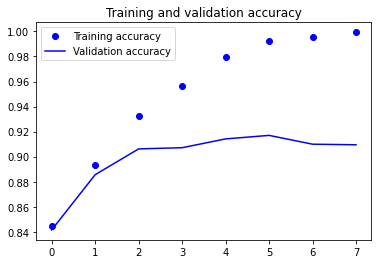

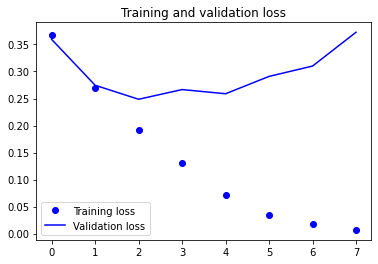

In [ ]:
run_model(model4, 'Experiment4_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9296    0.7773    0.8466       696
           1     0.9001    0.9715    0.9344      1437

    accuracy                         0.9081      2133
   macro avg     0.9148    0.8744    0.8905      2133
weighted avg     0.9097    0.9081    0.9058      2133



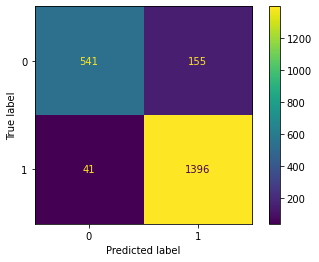

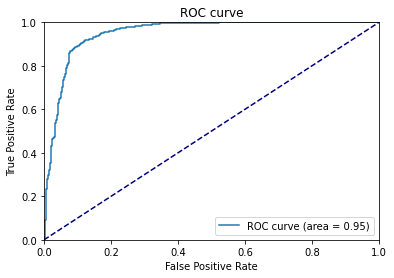

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_fine_tuning.h5'))

##### Experiment 5: two dense layers of 512 neurons 

In [ ]:
model5 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5')
set_trainable = False
for layer in model5.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model5, optimizer='rmsprop', learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8405
Epoch 00001: val_loss improved from inf to 0.32293, saving model to /content/models/Prova_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 85s 387ms/step - loss: 0.3613 - accuracy: 0.8405 - val_loss: 0.3229 - val_accuracy: 0.8612
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.8993
Epoch 00002: val_loss improved from 0.32293 to 0.27762, saving model to /content/models/Prova_fine_tuning.h5
200/200 [==============================] - 76s 381ms/step - loss: 0.2547 - accuracy: 0.8993 - val_loss: 0.2776 - val_accuracy: 0.8902
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9290
Epoch 00003: val_loss improved from 0.27762 to 0.24857, saving model to /content/models/Prova_fine_tuning.h5
200/200 [==============================] - 76s 381ms/step - loss: 0.1815 - accuracy: 0.9290 - val_loss: 0.2486 - val_accuracy: 0.9048
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9568
Epoch 00004: val_loss did not improve from 0.24857
200/200 [==============================] 

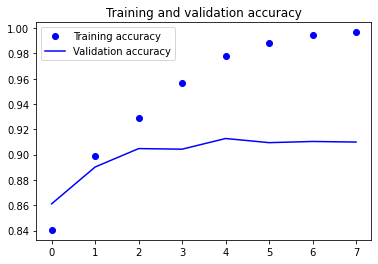

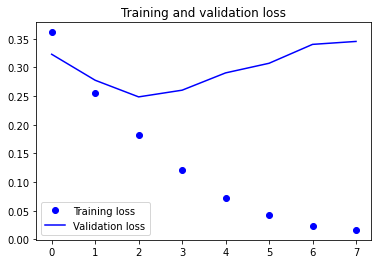

In [ ]:
run_model(model5, 'Experiment5_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8858    0.8132    0.8479       696
           1     0.9130    0.9492    0.9307      1437

    accuracy                         0.9048      2133
   macro avg     0.8994    0.8812    0.8893      2133
weighted avg     0.9041    0.9048    0.9037      2133



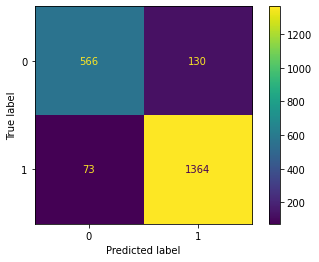

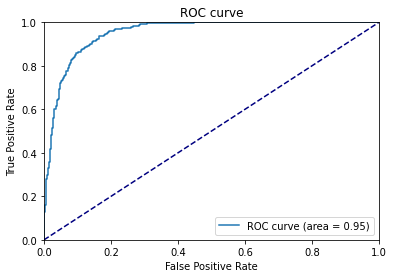

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_fine_tuning.h5'))

#### Unfreeze also the third block
We saw an improvement of our models, so we keep to unfreeze more layers. Now we unfreeze also the third block of our base network.

##### Experiment 6: one dense layer with 256 neurons and dropout

In [ ]:
model6 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model6.get_layer('base').layers:
    if layer.name == 'conv3_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model6, learning_rate=1e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8385
Epoch 00001: val_loss improved from inf to 0.29333, saving model to /content/models/Experiment6_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 133s 522ms/step - loss: 0.3806 - accuracy: 0.8385 - val_loss: 0.2933 - val_accuracy: 0.8799
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9076
Epoch 00002: val_loss improved from 0.29333 to 0.22775, saving model to /content/models/Experiment6_remove_blocks_fine_tuning.h5
200/200 [==============================] - 103s 514ms/step - loss: 0.2348 - accuracy: 0.9076 - val_loss: 0.2278 - val_accuracy: 0.9109
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9407
Epoch 00003: val_loss improved from 0.22775 to 0.19910, saving model to /content/models/Experiment6_remove_blocks_fine_tuning.h5
200/200 [==============================] - 103s 512ms/step - loss: 0.1611 - accuracy: 0.9407 - val_loss: 0.1991 - val_accuracy: 0.9226
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9647
Epoch 00004: val_loss improved from 0.19910 to 0.

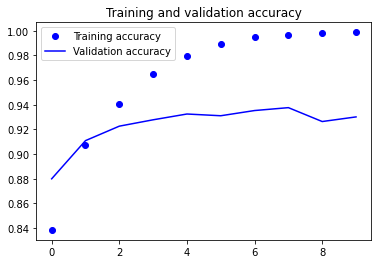

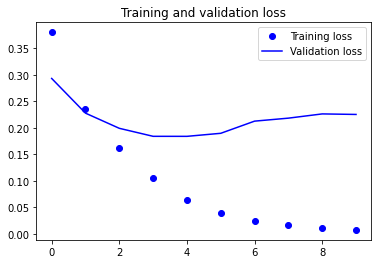

In [ ]:
run_model(model6, 'Experiment6_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9115    0.8736    0.8921       696
           1     0.9400    0.9589    0.9494      1437

    accuracy                         0.9311      2133
   macro avg     0.9258    0.9163    0.9208      2133
weighted avg     0.9307    0.9311    0.9307      2133



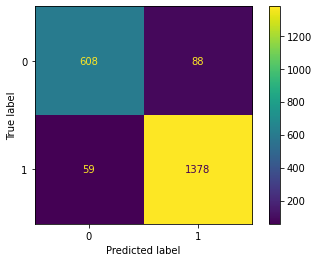

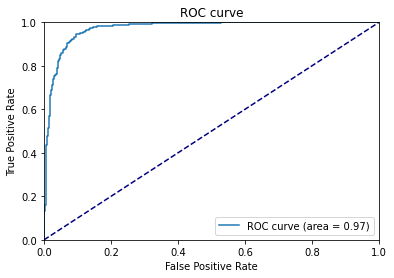

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment6_remove_blocks_fine_tuning.h5'))

##### Experiment 7: one dense layer with 512 neurons

In [ ]:
model7 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model7.get_layer('base').layers:
    if layer.name == 'conv3_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model7, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8469
Epoch 00001: val_loss improved from inf to 0.29658, saving model to /content/models/Experiment7_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 121s 550ms/step - loss: 0.3492 - accuracy: 0.8469 - val_loss: 0.2966 - val_accuracy: 0.8790
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9173
Epoch 00002: val_loss improved from 0.29658 to 0.22149, saving model to /content/models/Experiment7_remove_blocks_fine_tuning.h5
200/200 [==============================] - 107s 535ms/step - loss: 0.2223 - accuracy: 0.9173 - val_loss: 0.2215 - val_accuracy: 0.9128
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9486
Epoch 00003: val_loss did not improve from 0.22149
200/200 [==============================] - 106s 531ms/step - loss: 0.1443 - accuracy: 0.9486 - val_loss: 0.2374 - val_accuracy: 0.9142
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9725
Epoch 00004: val_loss did not improve from 0.22149
200/200 [==============================] - 106s 530ms/step - loss: 0.0886 - 

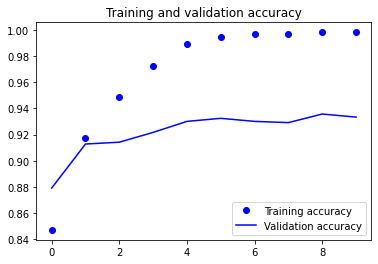

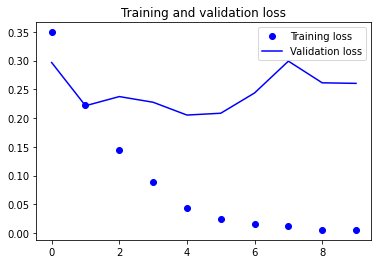

In [ ]:
run_model(model7, 'Experiment7_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9490    0.8563    0.9003       696
           1     0.9336    0.9777    0.9551      1437

    accuracy                         0.9381      2133
   macro avg     0.9413    0.9170    0.9277      2133
weighted avg     0.9386    0.9381    0.9372      2133



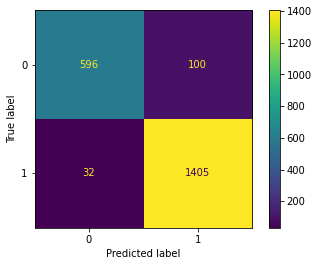

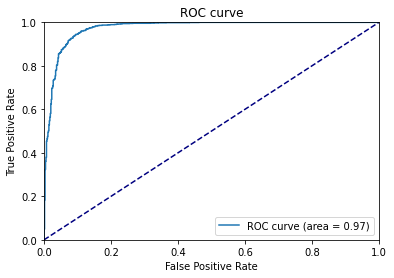

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment7_remove_blocks_fine_tuning.h5'))

#### Unfreeze also the second block
We try to unfreeze also the entire second block

##### Experiment 8: one dense layer with 256 neurons and dropout

In [ ]:
model8 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model8.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model8, learning_rate=1e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8624
Epoch 00001: val_loss improved from inf to 0.54006, saving model to /content/models/Experiment8_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 135s 620ms/step - loss: 0.3438 - accuracy: 0.8624 - val_loss: 0.5401 - val_accuracy: 0.8326
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9085
Epoch 00002: val_loss improved from 0.54006 to 0.27266, saving model to /content/models/Experiment8_remove_blocks_fine_tuning.h5
200/200 [==============================] - 123s 614ms/step - loss: 0.2256 - accuracy: 0.9085 - val_loss: 0.2727 - val_accuracy: 0.8996
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9465
Epoch 00003: val_loss improved from 0.27266 to 0.21313, saving model to /content/models/Experiment8_remove_blocks_fine_tuning.h5
200/200 [==============================] - 123s 613ms/step - loss: 0.1487 - accuracy: 0.9465 - val_loss: 0.2131 - val_accuracy: 0.9165
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9654
Epoch 00004: val_loss improved from 0.21313 to 0.

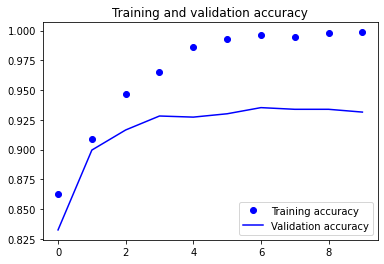

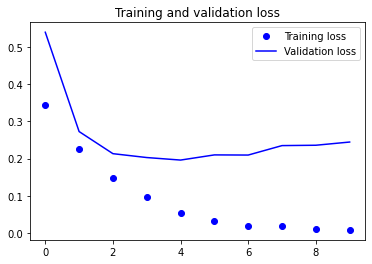

In [ ]:
run_model(model8, 'Experiment8_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9202    0.8951    0.9075       696
           1     0.9499    0.9624    0.9561      1437

    accuracy                         0.9405      2133
   macro avg     0.9350    0.9288    0.9318      2133
weighted avg     0.9402    0.9405    0.9402      2133



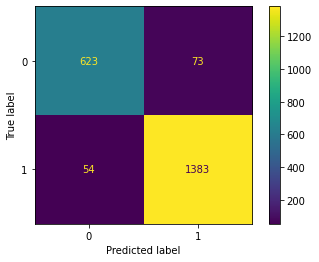

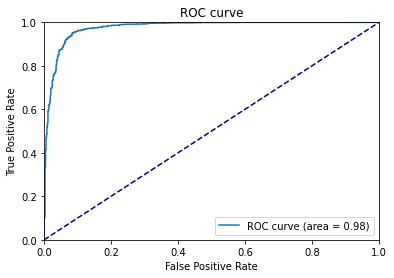

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment8_remove_blocks_fine_tuning.h5'))

##### Experiment 9: one dense layer with 512 neurons

In [ ]:
model9 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model9.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model9, learning_rate=1e-5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8746
Epoch 00001: val_loss improved from inf to 0.55808, saving model to /content/models/Experiment10_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 169s 765ms/step - loss: 0.3145 - accuracy: 0.8746 - val_loss: 0.5581 - val_accuracy: 0.8171
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.9231
Epoch 00002: val_loss improved from 0.55808 to 0.27380, saving model to /content/models/Experiment10_remove_blocks_fine_tuning.h5
200/200 [==============================] - 149s 746ms/step - loss: 0.2051 - accuracy: 0.9231 - val_loss: 0.2738 - val_accuracy: 0.8917
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9520
Epoch 00003: val_loss improved from 0.27380 to 0.19603, saving model to /content/models/Experiment10_remove_blocks_fine_tuning.h5
200/200 [==============================] - 149s 745ms/step - loss: 0.1344 - accuracy: 0.9520 - val_loss: 0.1960 - val_accuracy: 0.9226
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9772
Epoch 00004: val_loss improved from 0.19603 to 

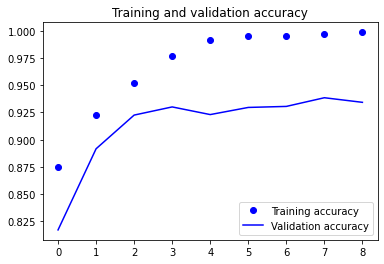

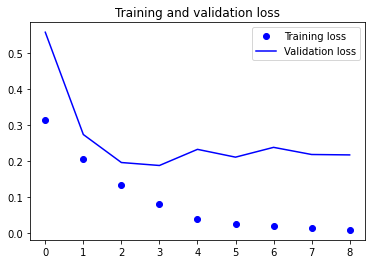

In [ ]:
run_model(model9, 'Experiment9_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9387    0.8807    0.9088       696
           1     0.9439    0.9722    0.9578      1437

    accuracy                         0.9423      2133
   macro avg     0.9413    0.9265    0.9333      2133
weighted avg     0.9422    0.9423    0.9418      2133



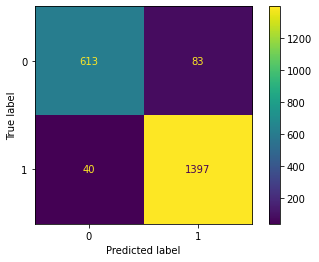

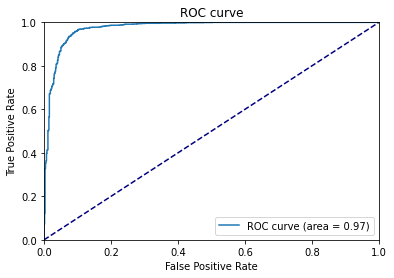

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment9_remove_blocks_fine_tuning.h5'))

#### Unfreeze all the base network
Let's try to unfreeze all the layers of the base network

##### Experiment 10: one dense layer with 256 neurons and dropout

In [ ]:
model10 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')
model10.trainable = True
compile_model(model10, learning_rate=1e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.8624
Epoch 00001: val_loss improved from inf to 0.61486, saving model to /content/models/Experiment9_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 139s 647ms/step - loss: 0.3356 - accuracy: 0.8624 - val_loss: 0.6149 - val_accuracy: 0.8349
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9179
Epoch 00002: val_loss improved from 0.61486 to 0.28437, saving model to /content/models/Experiment9_remove_blocks_fine_tuning.h5
200/200 [==============================] - 128s 640ms/step - loss: 0.2128 - accuracy: 0.9179 - val_loss: 0.2844 - val_accuracy: 0.8977
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9487
Epoch 00003: val_loss improved from 0.28437 to 0.19993, saving model to /content/models/Experiment9_remove_blocks_fine_tuning.h5
200/200 [==============================] - 128s 640ms/step - loss: 0.1440 - accuracy: 0.9487 - val_loss: 0.1999 - val_accuracy: 0.9226
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9662
Epoch 00004: val_loss improved from 0.19993 to 0.

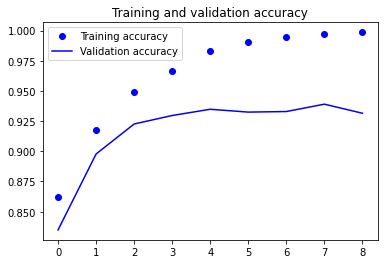

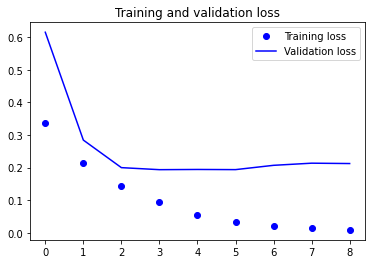

In [ ]:
run_model(model10, 'Experiment10_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9512    0.8678    0.9076       696
           1     0.9386    0.9784    0.9581      1437

    accuracy                         0.9423      2133
   macro avg     0.9449    0.9231    0.9328      2133
weighted avg     0.9427    0.9423    0.9416      2133



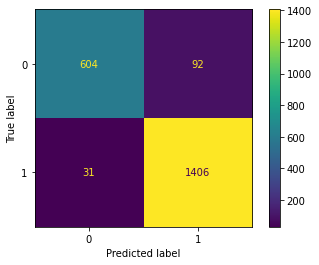

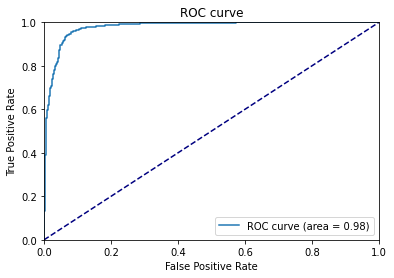

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment10_remove_blocks_fine_tuning.h5'))

##### Experiment 11: one dense layer with 512 neurons

In [ ]:
model11 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
model11.trainable = True
compile_model(model11, learning_rate=1e-5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.8738
Epoch 00001: val_loss improved from inf to 0.68285, saving model to /content/models/Experiment11_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 162s 781ms/step - loss: 0.3063 - accuracy: 0.8738 - val_loss: 0.6829 - val_accuracy: 0.8185
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9268
Epoch 00002: val_loss improved from 0.68285 to 0.22895, saving model to /content/models/Experiment11_remove_blocks_fine_tuning.h5
200/200 [==============================] - 155s 777ms/step - loss: 0.1923 - accuracy: 0.9268 - val_loss: 0.2289 - val_accuracy: 0.9118
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9570
Epoch 00003: val_loss improved from 0.22895 to 0.19938, saving model to /content/models/Experiment11_remove_blocks_fine_tuning.h5
200/200 [==============================] - 155s 776ms/step - loss: 0.1256 - accuracy: 0.9570 - val_loss: 0.1994 - val_accuracy: 0.9250
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9781
Epoch 00004: val_loss improved from 0.19938 to 

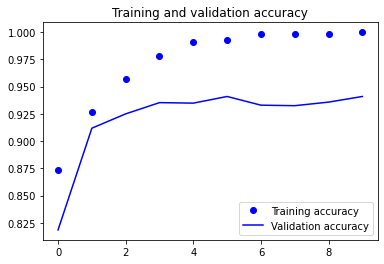

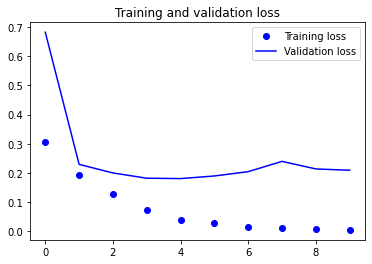

In [ ]:
run_model(model11, 'Experiment11_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9214    0.9095    0.9154       696
           1     0.9564    0.9624    0.9594      1437

    accuracy                         0.9451      2133
   macro avg     0.9389    0.9360    0.9374      2133
weighted avg     0.9450    0.9451    0.9451      2133



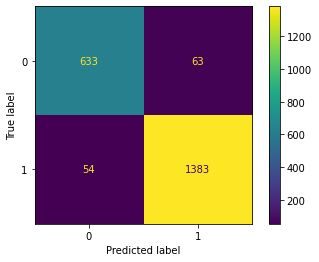

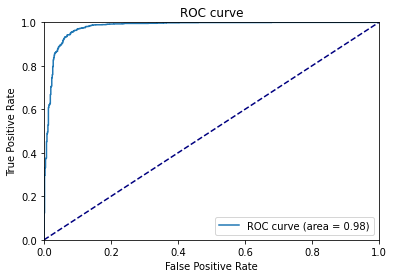

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment11_remove_blocks_fine_tuning.h5'))

##### Experiment 12: two dense layers of 512 neurons 

In [ ]:
model12 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5')
model12.trainable = True
compile_model(model12, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.8796
Epoch 00001: val_loss improved from inf to 0.60199, saving model to /content/models/Experiment12_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 130s 616ms/step - loss: 0.2981 - accuracy: 0.8796 - val_loss: 0.6020 - val_accuracy: 0.8232
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9214
Epoch 00002: val_loss improved from 0.60199 to 0.20781, saving model to /content/models/Experiment12_remove_blocks_fine_tuning.h5
200/200 [==============================] - 122s 610ms/step - loss: 0.1938 - accuracy: 0.9214 - val_loss: 0.2078 - val_accuracy: 0.9160
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9545
Epoch 00003: val_loss improved from 0.20781 to 0.20775, saving model to /content/models/Experiment12_remove_blocks_fine_tuning.h5
200/200 [==============================] - 122s 610ms/step - loss: 0.1218 - accuracy: 0.9545 - val_loss: 0.2077 - val_accuracy: 0.9207
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9783
Epoch 00004: val_loss improved from 0.20775 to 

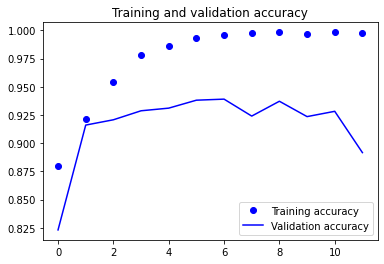

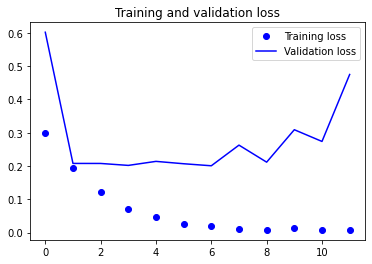

In [ ]:
run_model(model12, 'Experiment12_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9323    0.8908    0.9111       696
           1     0.9482    0.9687    0.9583      1437

    accuracy                         0.9433      2133
   macro avg     0.9403    0.9297    0.9347      2133
weighted avg     0.9430    0.9433    0.9429      2133



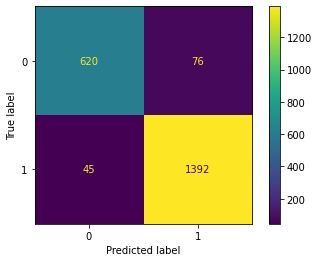

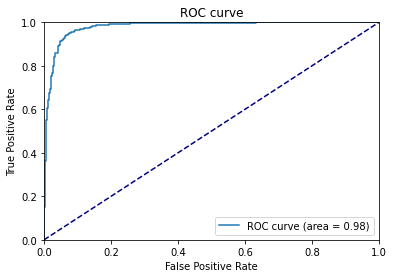

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment12_remove_blocks_fine_tuning.h5'))

# CLAHE
We will try now to use the dataset in which the images are preprocesses with CLAHE. We will test the performance with the best network previuosly found and we will compare the results. Unfortunately, no significant improvements were found.

## Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [ ]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/My Drive/Baldi_Cioffo/SplittedDataset_CLAHE.zip" -d "/content"

Mounted at /content/drive


## Set parameters

In [ ]:
DATASET_PATH = "/content/SplittedDataset_CLAHE"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

## Load dataset
The dataset, properly preprocessed, is now located in the local machine.

In [ ]:
set_seed()

train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Remove final block
As we did for the original dataset, here too we are going to remove the last block that deals with the high-level features of Imagenet

In [ ]:
conv_base = keras.applications.resnet.ResNet50(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'conv4_block6_out')].output, name='base')
base.trainable = False
base.summary()

Model: "base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                               

## Feature extraction
Firstly, we try the simplest approach in which we use the pretrained network to extract feature and we use our classifier to classify the images.

### Experiment 1: one dense layer with 256 neurons and dropout
This is the first best model found in the previous section with the standard dataset.

In [ ]:
# define the classifier
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.6767
Epoch 00001: val_loss improved from inf to 0.60354, saving model to /content/models/Experiment1_remove_blocks_feature_extraction_CLAHE.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 63s 254ms/step - loss: 0.7521 - accuracy: 0.6767 - val_loss: 0.6035 - val_accuracy: 0.6853
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.7253
Epoch 00002: val_loss did not improve from 0.60354
200/200 [==============================] - 49s 243ms/step - loss: 0.5786 - accuracy: 0.7253 - val_loss: 0.6196 - val_accuracy: 0.6829
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.7384
Epoch 00003: val_loss improved from 0.60354 to 0.48339, saving model to /content/models/Experiment1_remove_blocks_feature_extraction_CLAHE.h5
200/200 [==============================] - 49s 244ms/step - loss: 0.5417 - accuracy: 0.7384 - val_loss: 0.4834 - val_accuracy: 0.7730
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.7591
Epoch 00004: val_loss improved from 0.48339 to 0.41628, saving model to /content/models/Experiment1_remove_blocks_fea

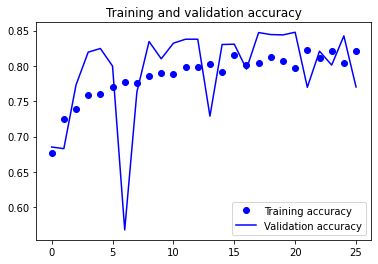

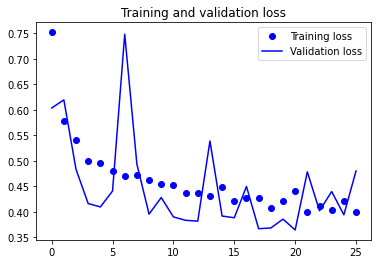

In [ ]:
run_model(model1, "Experiment1_remove_blocks_feature_extraction_CLAHE", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.8645    0.6968    0.7717       696
           1     0.8658    0.9471    0.9046      1437

    accuracy                         0.8654      2133
   macro avg     0.8652    0.8220    0.8381      2133
weighted avg     0.8654    0.8654    0.8612      2133



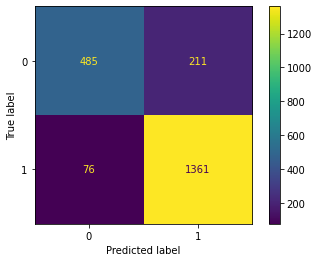

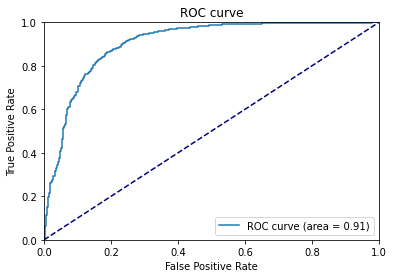

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction_CLAHE.h5'))

## Fine Tuning
Now we can fine-tune the base network to adapt it to extract more useful features in our images.

### Unfreeze up to the second block included
We tried directly to unfreeze up to the second block included, just to compare with the previous results. We can easily see that unfortunately there are no significative improvements, indeed the results are less satisfactory than the same network on the original dataset.

#### Experiment 1: one dense layer with 256 neurons and dropout

In [ ]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction_CLAHE.h5')

set_trainable = False
for layer in model1.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model1, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.8544
Epoch 00001: val_loss improved from inf to 0.48271, saving model to /content/models/Experiment1_remove_blocks_fine_tuning_CLAHE.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 129s 607ms/step - loss: 0.3406 - accuracy: 0.8544 - val_loss: 0.4827 - val_accuracy: 0.8480
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9112
Epoch 00002: val_loss improved from 0.48271 to 0.24510, saving model to /content/models/Experiment1_remove_blocks_fine_tuning_CLAHE.h5
200/200 [==============================] - 121s 602ms/step - loss: 0.2250 - accuracy: 0.9112 - val_loss: 0.2451 - val_accuracy: 0.9067
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9440
Epoch 00003: val_loss improved from 0.24510 to 0.21566, saving model to /content/models/Experiment1_remove_blocks_fine_tuning_CLAHE.h5
200/200 [==============================] - 120s 601ms/step - loss: 0.1527 - accuracy: 0.9440 - val_loss: 0.2157 - val_accuracy: 0.9160
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9687
Epoch 00004: val_loss did not improve

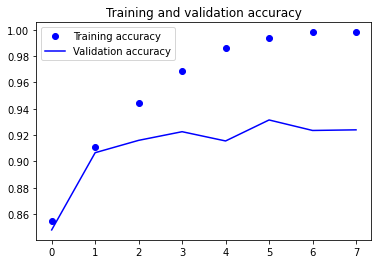

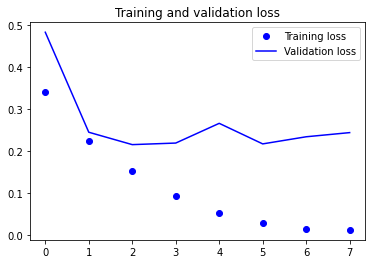

In [ ]:
run_model(model1, "Experiment1_remove_blocks_fine_tuning_CLAHE", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.9259    0.8261    0.8732       696
           1     0.9200    0.9680    0.9434      1437

    accuracy                         0.9217      2133
   macro avg     0.9229    0.8971    0.9083      2133
weighted avg     0.9219    0.9217    0.9205      2133



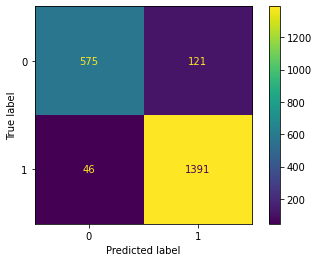

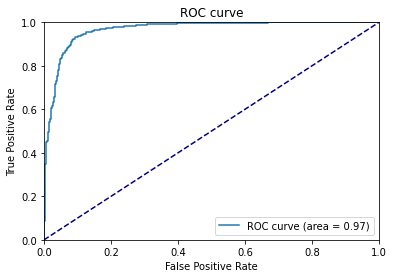

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_fine_tuning_CLAHE.h5'))